In [2]:
# %matplotlib inline
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import re

df = pd.read_csv('phl_2025.csv')

print(df.columns)
df.shape

Index(['ID', 'DoB', 'Age', 'Gender', 'Pre-procedure diagnosis',
       'Post-procedure diagnosis', 'Year(s) since procedure', 'Medications',
       'SBP R', 'DBP R', 'SBP L', 'DBP L', 'Heart rate', 'OSat', 'Weight',
       'Height', 'IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root',
       'Left atrium measure', 'Left atrium', 'LVEF (%)', 'LVEF (categorical)',
       'RV size', 'RV function', 'IVC', 'RA/Pres', 'LV contraction',
       'LV affected segment', 'LVH', 'E/A', 'Septum e'', 'Lateral e'', 'E/e'',
       'Aortic structure', 'LVOT diameter', 'AO V1 max', 'AO V2 max', 'PG',
       'MG', 'DI', 'AVA', 'Aortic regurgitation PHT', 'AI gradient',
       'Mitral valve structure', 'MR Vmax', 'MR gradient', 'MS PHT',
       'PHT area', 'MSA planimetry', 'MS MG (mmHg)', 'TR Vmax', 'TR PG',
       'TR Grading', 'RVSP', 'PV V1', 'PV V2', 'PS Max G', 'PS Grading',
       'PS location', 'VSD location', 'VSD shunting', 'ASD size',
       'ASD shunting', 'Discharged?'],
      dtype='object')


(152, 67)

In [3]:
# Master list of columns for Mitral-focused analysis
mdf = df[[
    # --- Demographics & Biometrics ---
    'Age', 'Gender', 'Weight', 'Height',
    
    # --- Primary Predictors (Mitral Disease Severity) ---
    'MR gradient', 'MS PHT', 
    'PHT area', 'MSA planimetry', 'MS MG (mmHg)',
    
    # --- Downstream Remodeling (Atrial & Right Heart) ---
    'Left atrium', 'Left atrium measure', 'RV size', 
    'RV function', 'RVSP', 'TR Grading',
    
    # --- Left Ventricular Function & Structure ---
    'LVEF (categorical)', 'LVIDd', 'LVIDs',
    
    # --- Clinical Context & Stratification ---
    'Pre-procedure diagnosis', 'Post-procedure diagnosis', 
    'Year(s) since procedure', 'Medications',
    
    # --- Vitals (Hemodynamic Baseline) ---
    'SBP L', 'DBP L', 'Heart rate', 'OSat'
]]

mdf.shape

(152, 26)

## Transcription integrity and data cleansing
Physical-to-digital transcription is the most common source of "human-in-the-loop" errors

In [5]:
# Combine both diagnosis columns into one series
combined_diagnoses = pd.concat([
    mdf['Pre-procedure diagnosis'], 
    mdf['Post-procedure diagnosis']
])

'''Split by comma (Notion's delimiter), explode into individual rows, 
strip whitespace, and capitalize for consistency.'''
all_diagnoses = (
    combined_diagnoses
    .str.split(',')
    .explode()
    .str.strip()
    .str.capitalize() # Ensures 'mitral stenosis' and 'Mitral stenosis' match
    .dropna()
)

# Create the unique list and the frequency count
unique_diagnoses = sorted(all_diagnoses.unique().tolist())
diagnoses_frequency = all_diagnoses.value_counts()

print(f"Total Unique Diagnosis Tags: {len(unique_diagnoses)}")
print("-" * 30)
with pd.option_context('display.max_rows', None):
    print(diagnoses_frequency)

Total Unique Diagnosis Tags: 94
------------------------------
Severe mitral stenosis                                                    41
Secundum atrial septal defect                                             22
Severe aortic stenosis                                                    20
Surgical aortic valve replacement                                         14
Severe mitral regurgitation                                               13
Bicuspid aortic valve                                                     12
Mitral valve percutaneous valvuloplasty                                   11
Severe pulmonary hypertension                                              9
Atrial fibrillation                                                        9
Critical aortic stenosis                                                   8
Surgical mitral valve replacement                                          8
Severe aortic regurgitation                                                7
Perimembranou

In [ ]:
''' Create a searchable version of the diagnosis without losing any tags
We split by the comma, strip extra spaces, and keep everything in a list '''
mdf['diag_list'] = mdf['Pre-procedure diagnosis'].str.split(',').apply(
    lambda x: [item.strip().lower() for item in x] if isinstance(x, list) else []
)

# This regex approach looks through the whole string, including everything after the comma
pattern = 'mitral'

df_mitral = mdf[
    mdf['Pre-procedure diagnosis'].str.contains(pattern, case=False, na=False) |
    mdf['Post-procedure diagnosis'].str.contains(pattern, case=False, na=False)
].copy()

# Create flags for the two main mitral pathologies
df_mitral['is_stenosis'] = df_mitral['Pre-procedure diagnosis'].str.contains('stenosis', case=False, na=False).astype(int)
df_mitral['is_regurgitation'] = df_mitral['Pre-procedure diagnosis'].str.contains('regurgitation', case=False, na=False).astype(int)

# Check how many patients have both (Multivalvular Mitral Disease)
both = df_mitral[(df_mitral['is_stenosis'] == 1) & (df_mitral['is_regurgitation'] == 1)]
print(f"Patients with combined MS and MR: {len(both)}")

Patients with combined MS and MR: 12


C:\Users\Admin\AppData\Local\Temp\ipykernel_11304\1327462241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['diag_list'] = mdf['Pre-procedure diagnosis'].str.split(',').apply(


In [ ]:
''' Split all entries by the pipe and "explode" them into a single list
This creates a series where every row is exactly one "Carvedilol 6.25 mg BID" entry '''
all_med_entries = df_mitral['Medications'].str.split('|').explode().str.strip().dropna()

# Extracting just the first word (usually the drug name) to see our list
drug_names_only = all_med_entries.str.split(' ').str[0].str.capitalize().unique()

print(f"Total Unique Drugs Found: {len(drug_names_only)}")
print("-" * 30)
print(drug_names_only)

Total Unique Drugs Found: 36
------------------------------
['Irbesartan' 'Carvedilol' 'Warfarin' 'Digoxin' 'Nifedipine' 'Furosemide'
 'Sildenafil' 'Amiodarone' 'Trimetazidine' 'Simvastatin' 'Dapaglifozin'
 'Sacubitril-valsartan' 'Losartan' 'Spironolactone' 'Rivaroxaban'
 'Levothyroxine' 'Enalapril' 'Aspirin' 'Lisinopril' 'Tadalafil'
 'Bisoprolol' 'Rosuvastatin' 'Ranolazine' 'Amlodipine' 'Gemfibrozil'
 'Clopidogrel' 'Valsartan' 'Propranolol' 'Metoprolol' 'Captopril'
 'Hydrochlorothiazide' 'Apixaban' 'Atenolol' 'Empaglifozin' 'Metformin'
 'Ciprofibrate']


In [ ]:
# Group medications into broader classes
drug_classes = {
    'Beta_Blockers': [
        'Carvedilol', 'Bisoprolol', 'Propranolol', 'Metoprolol', 'Atenolol'
    ],
    'RAAS_Inhibitors': [
        'Enalapril', 'Lisinopril', 'Losartan', 'Valsartan', 'Irbesartan', 
        'Captopril', 'Sacubitril-valsartan'
    ],
    'Diuretics_Loop': [
        'Furosemide'
    ],
    'Diuretics_Other': [
        'Spironolactone', 'Espironolactone', 'Hydrochlorothiazide'
    ],
    'Anticoagulants_Antiplatelets': [
        'Warfarin', 'Warfarine', 'Rivaroxaban', 'Apixaban', 'Aspirin', 'Clopidogrel'
    ],
    'Rate_Rhythm_Control': [
        'Digoxin', 'Amiodarone'
    ],
    'Calcium_Channel_Blockers': [
        'Nifedipine', 'Amlodipine'
    ],
    'SGLT2_Inhibitors': [
        'Dapaglifozin', 'Empaglifozin'
    ],
    'Pulmonary_Vasodilators': [
        'Sildenafil', 'Tadalafil'
    ],
    'Lipid_Lowering': [
        'Simvastatin', 'Rosuvastatin', 'Rosuvastatine', 'Gemfibrozil', 'Ciprofibrate'
    ],
    'Anti_Ischemic_Other': [
        'Trimetazidine', 'Ranolazine'
    ],
    'Metabolic_Endocrine': [
        'Levothyroxine', 'Metformin'
    ]
}

In [ ]:
freq_map = {
    'qd': 1, 'bid': 2, 'tid': 3, 'qid': 4
}

def get_med_data(med_string, drug_list):
    """
    Parses the pipe-separated string for a specific class of drugs.
    Returns: (Specific_Drug_Name, Total_Daily_Dose)
    """
    if pd.isna(med_string):
        return "None", 0.0
    
    # Split by your pipe delimiter
    individual_meds = [m.strip().lower() for m in str(med_string).split('|')]
    
    for med_entry in individual_meds:
        # Check if any drug from our dictionary class is in this entry
        matched_drug = next((d for d in drug_list if d.lower() in med_entry), None)
        
        if matched_drug:
            # 1. Extract base dose (the number)
            # Regex looks for digits, handles decimals like 6.25
            dose_match = re.search(r'(\d+\.?\d*)', med_entry)
            base_dose = float(dose_match.group(1)) if dose_match else 0.0
            
            # 2. Determine frequency multiplier
            multiplier = 1 # Default to once a day
            for freq, value in freq_map.items():
                if freq in med_entry:
                    multiplier = value
                    break
            
            return matched_drug.capitalize(), base_dose * multiplier
            
    return "None", 0.0

# 2. Run the loop across all classes in your dictionary
for category, drugs in drug_classes.items():
    name_col = f"{category}_name"
    dose_col = f"{category}_tdd"
    
    # Apply the function to create the two new columns for each class
    mdf[[name_col, dose_col]] = mdf['Medications'].apply(
        lambda x: pd.Series(get_med_data(x, drugs))
    )

# Create a list of all newly created columns
med_columns = []
for category in drug_classes.keys():
    med_columns.extend([f"{category}_name", f"{category}_tdd"])

# Print the first 10 rows of these columns
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    print(mdf[med_columns])

C:\Users\Admin\AppData\Local\Temp\ipykernel_11304\2137212018.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf[[name_col, dose_col]] = mdf['Medications'].apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_11304\2137212018.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf[[name_col, dose_col]] = mdf['Medications'].apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_11304\2137212018.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

    Beta_Blockers_name  Beta_Blockers_tdd RAAS_Inhibitors_name  \
0           Metoprolol              50.00                 None   
1                 None               0.00                 None   
2           Carvedilol               6.25           Irbesartan   
3                 None               0.00                 None   
4                 None               0.00                 None   
..                 ...                ...                  ...   
147         Carvedilol              25.00                 None   
148         Carvedilol               6.25             Losartan   
149               None               0.00            Enalapril   
150               None               0.00                 None   
151         Carvedilol              12.50            Captopril   

     RAAS_Inhibitors_tdd Diuretics_Loop_name  Diuretics_Loop_tdd  \
0                    0.0                None                 0.0   
1                    0.0                None                 0.0   
2  

C:\Users\Admin\AppData\Local\Temp\ipykernel_11304\2137212018.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf[[name_col, dose_col]] = mdf['Medications'].apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_11304\2137212018.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf[[name_col, dose_col]] = mdf['Medications'].apply(


In [ ]:
# Replace '0' with the index of the patient you want to inspect
patient_idx = 100 

print(f"Original Text: {mdf.loc[patient_idx, 'Medications']}")
print("-" * 30)

for category in drug_classes.keys():
    name = mdf.loc[patient_idx, f"{category}_name"]
    dose = mdf.loc[patient_idx, f"{category}_tdd"]
    
    if name != "None":
        print(f"{category:25} | Name: {name:15} | TDD: {dose} mg")

Original Text: Bisoprolol 1.25 mg QD | Spironolactone 12.5 mg QD
------------------------------
Beta_Blockers             | Name: Bisoprolol      | TDD: 1.25 mg
Diuretics_Other           | Name: Spironolactone  | TDD: 12.5 mg


In [ ]:
# Define the intervention markers based on your unique list
replacement_markers = 'replacement|surgical valve'
valvuloplasty_markers = 'valvuloplasty'

def identify_valve_status(row):
    combined = f"{row['Pre-procedure diagnosis']} {row['Post-procedure diagnosis']}".lower()
    
    if re.search(replacement_markers, combined):
        return 'Replacement'
    elif re.search(valvuloplasty_markers, combined):
        return 'Post-Valvuloplasty'
    else:
        return 'Native'

df_mitral['valve_status'] = df_mitral.apply(identify_valve_status, axis=1)

df_native = df_mitral[df_mitral['valve_status'] == 'Native']
df_valvuloplasty = df_mitral[df_mitral['valve_status'] == 'Post-Valvuloplasty']
df_replacement = df_mitral[df_mitral['valve_status'] == 'Replacement']

In [ ]:
# Define keywords for the two main pathologies
ms_keywords = 'stenosis'
mr_keywords = 'regurgitation'

# Apply the logic to identify pathology
df_mitral['is_ms'] = df_mitral['Pre-procedure diagnosis'].str.contains(ms_keywords, case=False, na=False).astype(int)
df_mitral['is_mr'] = df_mitral['Pre-procedure diagnosis'].str.contains(mr_keywords, case=False, na=False).astype(int)

def refine_phenotype(row):
    if row['is_ms'] == 1 and row['is_mr'] == 1:
        return 'Double Valvular'
    elif row['is_ms'] == 1:
        return 'Pure MS'
    elif row['is_mr'] == 1:
        return 'Pure MR'
    else:
        return 'Other'

df_mitral['mitral_phenotype'] = df_mitral.apply(refine_phenotype, axis=1)

df_pure_ms = df_mitral[df_mitral['mitral_phenotype'] == 'Pure MS']
df_pure_mr = df_mitral[df_mitral['mitral_phenotype'] == 'Pure MR']
df_double_valvular = df_mitral[df_mitral['mitral_phenotype'] == 'Double Valvular']

# Cross-tabulate to see the bias
print("Valve Status vs Pathology Phenotype")
print("-" * 30)
print(pd.crosstab(df_mitral['valve_status'], df_mitral['mitral_phenotype']))

Valve Status vs Pathology Phenotype
------------------------------
mitral_phenotype    Double Valvular  Other  Pure MR  Pure MS
valve_status                                                
Native                            9      2        9       20
Post-Valvuloplasty                2      0        1        9
Replacement                       1      0        1        6


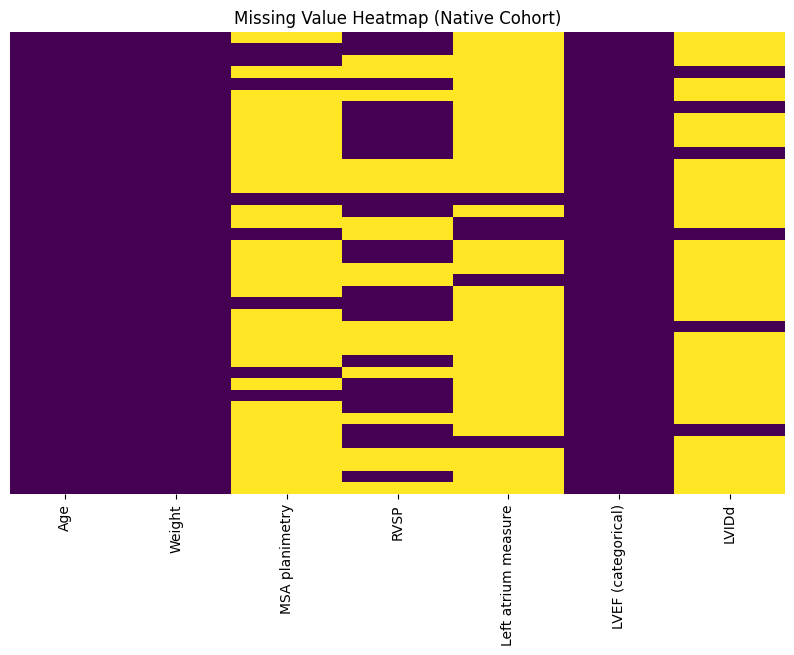

Percentage of Missing Values
------------------------------
Post-procedure diagnosis    97.5
Year(s) since procedure     97.5
MR gradient                 95.0
TR Grading                  95.0
RV function                 92.5
Left atrium measure         87.5
LVIDs                       87.5
LVIDd                       85.0
RV size                     82.5
MSA planimetry              80.0
Left atrium                 65.0
MS PHT                      65.0
PHT area                    55.0
MS MG (mmHg)                47.5
RVSP                        45.0
dtype: float64


In [ ]:
# Focusing on the Native Cohort for the analysis
missing_data = df_native[['Age', 'Weight', 'MSA planimetry', 'RVSP', 
                          'Left atrium measure', 'LVEF (categorical)', 'LVIDd',
                          ]].isnull()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_data, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Value Heatmap (Native Cohort)')
plt.show()

# Precise percentage report
missing_pct = df_native.isnull().sum() / len(df_native) * 100
print("Percentage of Missing Values")
print("-" * 30)
print(missing_pct[missing_pct > 0].sort_values(ascending=False))